# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

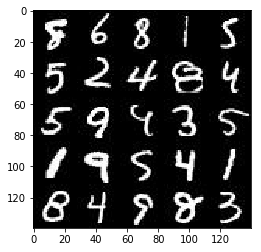

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

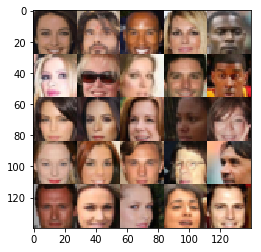

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, filters=128, kernel_size=5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha*conv1, conv1)
        # 14*14*128
        
        conv2 = tf.layers.conv2d(conv1, filters=256, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        # 7*7*256
        
        conv3 = tf.layers.conv2d(conv2, filters=512, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        # 3*3*512
        
        flat = tf.reshape(conv3, [-1, np.prod(conv3.get_shape().as_list()[1:])])
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)

    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.reshape(tf.layers.dense(z, 3*3*512), [-1, 3, 3, 512])
        x = tf.maximum(alpha*x, x)
        # 3*3*512
        
        c1 = tf.layers.conv2d_transpose(x, filters=256, kernel_size=3, strides=2, padding='valid')
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(alpha*c1, c1)
        # 7*7*256
        
        c2 = tf.layers.conv2d_transpose(c1, filters=128, kernel_size=2, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.maximum(alpha*c2, c2)
        # 14*14*128
        
        c3 = tf.layers.conv2d_transpose(c2, filters=out_channel_dim, kernel_size=2, strides=2, padding='same')
        # 28*28*out_channel_dim
        
        output = tf.tanh(c3)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_outputs, d_fake_logits = discriminator(g_outputs, reuse=True)
    
    d_real_losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits))
    d_fake_losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits))
    g_losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits))
    d_loss = tf.reduce_mean([d_real_losses, d_fake_losses])
    g_loss = tf.reduce_mean(g_losses)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # g_vars = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    # d_vars = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    img_width, img_height, img_channels = data_shape[1:]
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    d_run_losses, g_run_losses = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                batch_images *= 2  # scale image from [-.5 .5] to [-1, 1]
                d_batch_loss, g_batch_loss, _, _ = sess.run(
                    [d_loss, g_loss, d_opt, g_opt],
                    feed_dict={
                        input_real: batch_images,
                        input_z: np.random.uniform(-1, 1, size=[batch_size, z_dim])
                    })
                
                d_run_losses.append(d_batch_loss)
                g_run_losses.append(g_batch_loss)
                
                if (batch_i % 10 == 0):
                    print('epoch %d batch %d, d_loss: %f g_loss %f' % (epoch_i, batch_i, d_batch_loss, g_batch_loss))
                if (batch_i % 100 == 0):
                    show_generator_output(sess, 24, input_z, img_channels, data_image_mode)
                    
    return d_run_losses, g_run_losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 0 batch 10, d_loss: 0.018696 g_loss 20.784595
epoch 0 batch 20, d_loss: 0.138329 g_loss 13.771214
epoch 0 batch 30, d_loss: 0.253164 g_loss 1.984631
epoch 0 batch 40, d_loss: 3.151094 g_loss 0.024726
epoch 0 batch 50, d_loss: 1.916669 g_loss 0.127994
epoch 0 batch 60, d_loss: 0.182324 g_loss 2.704402
epoch 0 batch 70, d_loss: 0.558605 g_loss 1.038146
epoch 0 batch 80, d_loss: 0.235542 g_loss 2.010354
epoch 0 batch 90, d_loss: 0.370893 g_loss 1.318201
epoch 0 batch 100, d_loss: 0.316557 g_loss 1.857005


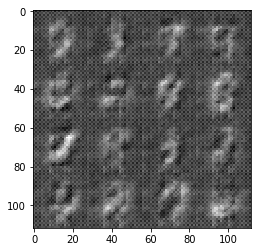

epoch 0 batch 110, d_loss: 0.361642 g_loss 4.501637
epoch 0 batch 120, d_loss: 1.103262 g_loss 7.784671
epoch 0 batch 130, d_loss: 0.416797 g_loss 1.006097
epoch 0 batch 140, d_loss: 0.264816 g_loss 2.479396
epoch 0 batch 150, d_loss: 0.276983 g_loss 2.925199
epoch 0 batch 160, d_loss: 0.325563 g_loss 1.396949
epoch 0 batch 170, d_loss: 0.730046 g_loss 0.479925
epoch 0 batch 180, d_loss: 0.266237 g_loss 1.495683
epoch 0 batch 190, d_loss: 0.987658 g_loss 0.313857
epoch 0 batch 200, d_loss: 0.275520 g_loss 3.718060


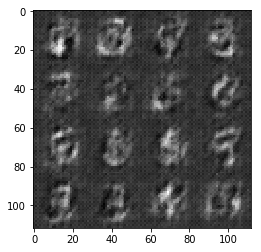

epoch 0 batch 210, d_loss: 0.205999 g_loss 2.104548
epoch 0 batch 220, d_loss: 0.200408 g_loss 2.457055
epoch 0 batch 230, d_loss: 0.469660 g_loss 0.906117
epoch 0 batch 240, d_loss: 1.170203 g_loss 0.291942
epoch 0 batch 250, d_loss: 0.231178 g_loss 1.592111
epoch 0 batch 260, d_loss: 0.247926 g_loss 1.518925
epoch 0 batch 270, d_loss: 0.332160 g_loss 5.103254
epoch 0 batch 280, d_loss: 0.183064 g_loss 2.033201
epoch 0 batch 290, d_loss: 0.147351 g_loss 2.789460
epoch 0 batch 300, d_loss: 0.159880 g_loss 3.350315


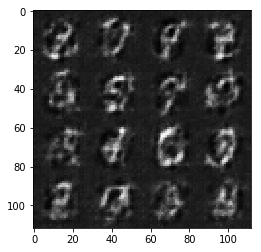

epoch 0 batch 310, d_loss: 0.146812 g_loss 3.639113
epoch 0 batch 320, d_loss: 0.209582 g_loss 1.952957
epoch 0 batch 330, d_loss: 0.126084 g_loss 3.421976
epoch 0 batch 340, d_loss: 0.233058 g_loss 2.031186
epoch 0 batch 350, d_loss: 0.249621 g_loss 1.738023
epoch 0 batch 360, d_loss: 0.409732 g_loss 6.168731
epoch 0 batch 370, d_loss: 0.178960 g_loss 2.947642
epoch 0 batch 380, d_loss: 0.449940 g_loss 5.791318
epoch 0 batch 390, d_loss: 0.097138 g_loss 2.519547
epoch 0 batch 400, d_loss: 0.830527 g_loss 7.166501


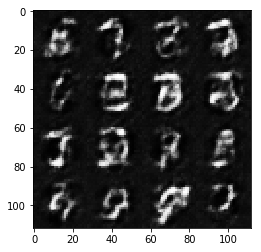

epoch 0 batch 410, d_loss: 0.140504 g_loss 3.183922
epoch 0 batch 420, d_loss: 0.214863 g_loss 1.692775
epoch 0 batch 430, d_loss: 0.166363 g_loss 3.138503
epoch 0 batch 440, d_loss: 0.140101 g_loss 5.099098
epoch 0 batch 450, d_loss: 0.133583 g_loss 2.151031
epoch 0 batch 460, d_loss: 0.218364 g_loss 2.292080
epoch 0 batch 470, d_loss: 0.150449 g_loss 2.485047
epoch 0 batch 480, d_loss: 0.538291 g_loss 1.198886
epoch 0 batch 490, d_loss: 0.168525 g_loss 2.798969
epoch 0 batch 500, d_loss: 0.269744 g_loss 4.616181


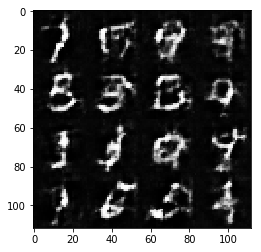

epoch 0 batch 510, d_loss: 0.887634 g_loss 8.211266
epoch 0 batch 520, d_loss: 0.269773 g_loss 3.815779
epoch 0 batch 530, d_loss: 0.175630 g_loss 2.012372
epoch 0 batch 540, d_loss: 0.194568 g_loss 4.191732
epoch 0 batch 550, d_loss: 0.264678 g_loss 2.996566
epoch 0 batch 560, d_loss: 0.382712 g_loss 3.509581
epoch 0 batch 570, d_loss: 0.192108 g_loss 3.188017
epoch 0 batch 580, d_loss: 0.139067 g_loss 3.324810
epoch 0 batch 590, d_loss: 0.201490 g_loss 2.066854
epoch 0 batch 600, d_loss: 0.593474 g_loss 4.614704


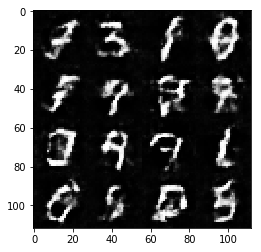

epoch 0 batch 610, d_loss: 0.227146 g_loss 1.727672
epoch 0 batch 620, d_loss: 0.476879 g_loss 4.841938
epoch 0 batch 630, d_loss: 0.320076 g_loss 1.348034
epoch 0 batch 640, d_loss: 0.394870 g_loss 4.695580
epoch 0 batch 650, d_loss: 0.193584 g_loss 3.271957
epoch 0 batch 660, d_loss: 0.684544 g_loss 0.655157
epoch 0 batch 670, d_loss: 0.284885 g_loss 3.074403
epoch 0 batch 680, d_loss: 0.815194 g_loss 4.815525
epoch 0 batch 690, d_loss: 0.271083 g_loss 2.168912
epoch 0 batch 700, d_loss: 0.236524 g_loss 1.661755


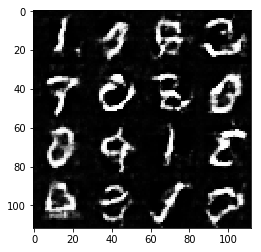

epoch 0 batch 710, d_loss: 0.726724 g_loss 6.128785
epoch 0 batch 720, d_loss: 0.409107 g_loss 1.084841
epoch 0 batch 730, d_loss: 0.215229 g_loss 3.418384
epoch 0 batch 740, d_loss: 0.185745 g_loss 2.280443
epoch 0 batch 750, d_loss: 0.381548 g_loss 1.392895
epoch 0 batch 760, d_loss: 0.240134 g_loss 2.798971
epoch 0 batch 770, d_loss: 0.285762 g_loss 2.326100
epoch 0 batch 780, d_loss: 0.162648 g_loss 2.289755
epoch 0 batch 790, d_loss: 0.375039 g_loss 3.777188
epoch 0 batch 800, d_loss: 0.796752 g_loss 0.513410


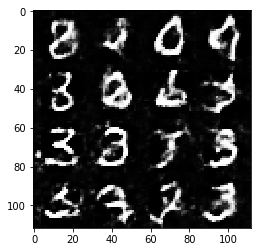

epoch 0 batch 810, d_loss: 0.425059 g_loss 1.173202
epoch 0 batch 820, d_loss: 0.485785 g_loss 1.129098
epoch 0 batch 830, d_loss: 0.229457 g_loss 3.532748
epoch 0 batch 840, d_loss: 0.257477 g_loss 2.067426
epoch 0 batch 850, d_loss: 0.220555 g_loss 2.170049
epoch 0 batch 860, d_loss: 0.161910 g_loss 2.726936
epoch 0 batch 870, d_loss: 0.184964 g_loss 2.007112
epoch 0 batch 880, d_loss: 0.216999 g_loss 2.126195
epoch 0 batch 890, d_loss: 0.361988 g_loss 2.874080
epoch 0 batch 900, d_loss: 0.470002 g_loss 0.868125


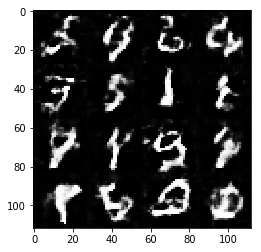

epoch 0 batch 910, d_loss: 0.285489 g_loss 1.405793
epoch 0 batch 920, d_loss: 0.240057 g_loss 2.265358
epoch 0 batch 930, d_loss: 0.287328 g_loss 3.447812
epoch 1 batch 10, d_loss: 0.240588 g_loss 1.804096
epoch 1 batch 20, d_loss: 0.214509 g_loss 1.953556
epoch 1 batch 30, d_loss: 0.158207 g_loss 3.012231
epoch 1 batch 40, d_loss: 0.257524 g_loss 1.411454
epoch 1 batch 50, d_loss: 0.718557 g_loss 0.767476
epoch 1 batch 60, d_loss: 0.241656 g_loss 2.693471
epoch 1 batch 70, d_loss: 0.150503 g_loss 2.389209
epoch 1 batch 80, d_loss: 0.157985 g_loss 2.399594
epoch 1 batch 90, d_loss: 0.551983 g_loss 1.022376
epoch 1 batch 100, d_loss: 0.225502 g_loss 2.691535


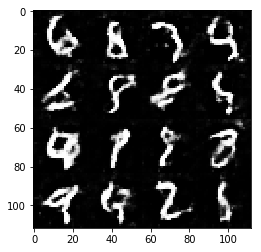

epoch 1 batch 110, d_loss: 0.157239 g_loss 2.927908
epoch 1 batch 120, d_loss: 0.262570 g_loss 3.420367
epoch 1 batch 130, d_loss: 0.261104 g_loss 1.601635
epoch 1 batch 140, d_loss: 0.160327 g_loss 3.216529
epoch 1 batch 150, d_loss: 0.220962 g_loss 3.885522
epoch 1 batch 160, d_loss: 0.806980 g_loss 4.403311
epoch 1 batch 170, d_loss: 0.431076 g_loss 1.083602
epoch 1 batch 180, d_loss: 0.183857 g_loss 2.401982
epoch 1 batch 190, d_loss: 0.139579 g_loss 3.455462
epoch 1 batch 200, d_loss: 0.141631 g_loss 2.376394


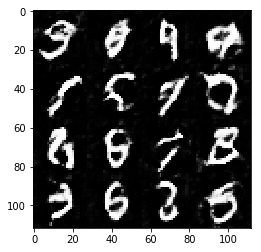

epoch 1 batch 210, d_loss: 0.211333 g_loss 3.541003
epoch 1 batch 220, d_loss: 0.154672 g_loss 2.127114
epoch 1 batch 230, d_loss: 0.145772 g_loss 2.417071
epoch 1 batch 240, d_loss: 0.327109 g_loss 1.170046
epoch 1 batch 250, d_loss: 0.213744 g_loss 1.862595
epoch 1 batch 260, d_loss: 0.123473 g_loss 4.289252
epoch 1 batch 270, d_loss: 0.120833 g_loss 3.892876
epoch 1 batch 280, d_loss: 0.159364 g_loss 3.746111
epoch 1 batch 290, d_loss: 0.077484 g_loss 3.647998
epoch 1 batch 300, d_loss: 1.865293 g_loss 0.111871


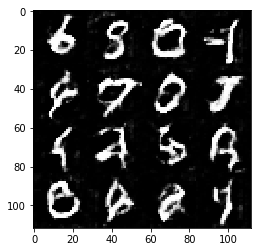

epoch 1 batch 310, d_loss: 0.214528 g_loss 2.833202
epoch 1 batch 320, d_loss: 0.465650 g_loss 1.029980
epoch 1 batch 330, d_loss: 0.153600 g_loss 3.585768
epoch 1 batch 340, d_loss: 0.065034 g_loss 3.519303
epoch 1 batch 350, d_loss: 0.109919 g_loss 3.105061
epoch 1 batch 360, d_loss: 0.481548 g_loss 3.705143
epoch 1 batch 370, d_loss: 0.312842 g_loss 3.846781
epoch 1 batch 380, d_loss: 0.163953 g_loss 3.059198
epoch 1 batch 390, d_loss: 1.401664 g_loss 5.155603
epoch 1 batch 400, d_loss: 0.659034 g_loss 0.676564


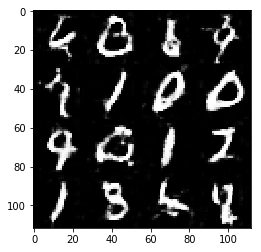

epoch 1 batch 410, d_loss: 0.303007 g_loss 2.085330
epoch 1 batch 420, d_loss: 0.380179 g_loss 1.255331
epoch 1 batch 430, d_loss: 0.465355 g_loss 4.237548
epoch 1 batch 440, d_loss: 0.217084 g_loss 1.925310
epoch 1 batch 450, d_loss: 0.216023 g_loss 3.781037
epoch 1 batch 460, d_loss: 0.125424 g_loss 3.203696
epoch 1 batch 470, d_loss: 0.147997 g_loss 2.182309
epoch 1 batch 480, d_loss: 0.147269 g_loss 2.443459
epoch 1 batch 490, d_loss: 0.203124 g_loss 3.884221
epoch 1 batch 500, d_loss: 0.438616 g_loss 4.112322


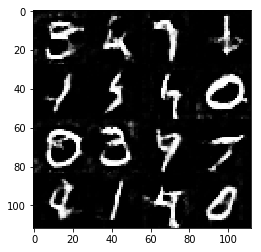

epoch 1 batch 510, d_loss: 1.566771 g_loss 5.842993
epoch 1 batch 520, d_loss: 0.389227 g_loss 1.110065
epoch 1 batch 530, d_loss: 0.211301 g_loss 2.096960
epoch 1 batch 540, d_loss: 0.207473 g_loss 2.204444
epoch 1 batch 550, d_loss: 0.128276 g_loss 2.930414
epoch 1 batch 560, d_loss: 0.660050 g_loss 0.833311
epoch 1 batch 570, d_loss: 0.289888 g_loss 2.185208
epoch 1 batch 580, d_loss: 0.237769 g_loss 2.984984
epoch 1 batch 590, d_loss: 0.143552 g_loss 2.317142
epoch 1 batch 600, d_loss: 0.315377 g_loss 3.131899


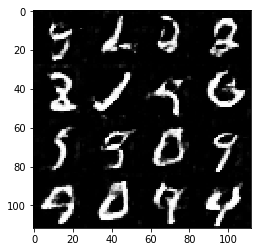

epoch 1 batch 610, d_loss: 1.454573 g_loss 0.126256
epoch 1 batch 620, d_loss: 0.196516 g_loss 2.532087
epoch 1 batch 630, d_loss: 0.325908 g_loss 3.661333
epoch 1 batch 640, d_loss: 0.127410 g_loss 2.905572
epoch 1 batch 650, d_loss: 0.129665 g_loss 3.414697
epoch 1 batch 660, d_loss: 0.251275 g_loss 1.733613
epoch 1 batch 670, d_loss: 0.687391 g_loss 0.548969
epoch 1 batch 680, d_loss: 0.200217 g_loss 2.224138
epoch 1 batch 690, d_loss: 0.131835 g_loss 2.729256
epoch 1 batch 700, d_loss: 0.260982 g_loss 1.937784


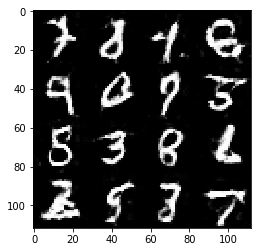

epoch 1 batch 710, d_loss: 0.726742 g_loss 3.932650
epoch 1 batch 720, d_loss: 0.296184 g_loss 1.425762
epoch 1 batch 730, d_loss: 0.300576 g_loss 2.867687
epoch 1 batch 740, d_loss: 0.183411 g_loss 2.939097
epoch 1 batch 750, d_loss: 0.630476 g_loss 0.612827
epoch 1 batch 760, d_loss: 0.188662 g_loss 2.395474
epoch 1 batch 770, d_loss: 0.227688 g_loss 2.188577
epoch 1 batch 780, d_loss: 0.135935 g_loss 2.649658
epoch 1 batch 790, d_loss: 0.238313 g_loss 1.675574
epoch 1 batch 800, d_loss: 0.382530 g_loss 1.540174


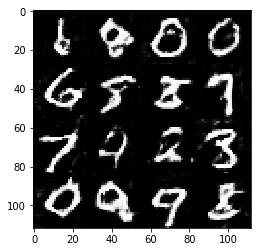

epoch 1 batch 810, d_loss: 0.220560 g_loss 2.792807
epoch 1 batch 820, d_loss: 0.269867 g_loss 2.793843
epoch 1 batch 830, d_loss: 0.108622 g_loss 2.736032
epoch 1 batch 840, d_loss: 0.235710 g_loss 1.977485
epoch 1 batch 850, d_loss: 0.186662 g_loss 1.963973
epoch 1 batch 860, d_loss: 0.294307 g_loss 4.940956
epoch 1 batch 870, d_loss: 0.392350 g_loss 0.984774
epoch 1 batch 880, d_loss: 0.446309 g_loss 1.274131
epoch 1 batch 890, d_loss: 0.372295 g_loss 3.349594
epoch 1 batch 900, d_loss: 0.271304 g_loss 1.494658


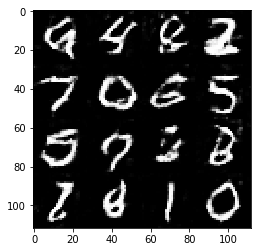

epoch 1 batch 910, d_loss: 0.200879 g_loss 2.405626
epoch 1 batch 920, d_loss: 0.451162 g_loss 1.502399
epoch 1 batch 930, d_loss: 0.405521 g_loss 1.073659


In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_loss, g_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

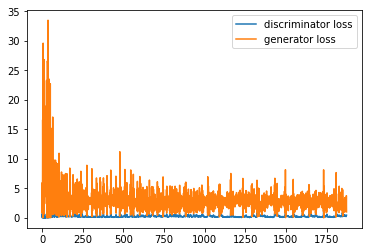

In [44]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.legend(['discriminator loss', 'generator loss'])

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 0 batch 10, d_loss: 0.079891 g_loss 22.253197
epoch 0 batch 20, d_loss: 0.000006 g_loss 25.314135
epoch 0 batch 30, d_loss: 1.438145 g_loss 1.115795
epoch 0 batch 40, d_loss: 0.043114 g_loss 22.990368
epoch 0 batch 50, d_loss: 0.006585 g_loss 21.301056
epoch 0 batch 60, d_loss: 0.003354 g_loss 7.433847
epoch 0 batch 70, d_loss: 0.958790 g_loss 0.873182
epoch 0 batch 80, d_loss: 0.437633 g_loss 1.529379
epoch 0 batch 90, d_loss: 0.098551 g_loss 3.139004
epoch 0 batch 100, d_loss: 0.154587 g_loss 5.006093


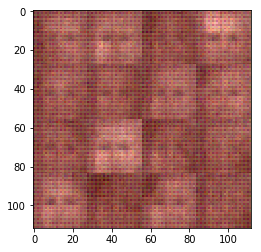

epoch 0 batch 110, d_loss: 0.227642 g_loss 3.541321
epoch 0 batch 120, d_loss: 0.125398 g_loss 3.136374
epoch 0 batch 130, d_loss: 0.499993 g_loss 6.579792
epoch 0 batch 140, d_loss: 0.812906 g_loss 7.910970
epoch 0 batch 150, d_loss: 0.139151 g_loss 3.915794
epoch 0 batch 160, d_loss: 0.340502 g_loss 1.484972
epoch 0 batch 170, d_loss: 0.333927 g_loss 1.198126
epoch 0 batch 180, d_loss: 0.690954 g_loss 5.098006
epoch 0 batch 190, d_loss: 0.318124 g_loss 2.280194
epoch 0 batch 200, d_loss: 0.279567 g_loss 1.644222


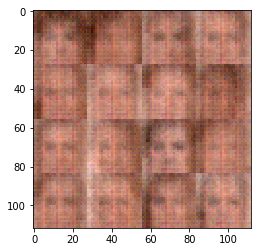

epoch 0 batch 210, d_loss: 0.865107 g_loss 7.268481
epoch 0 batch 220, d_loss: 0.301281 g_loss 4.848313
epoch 0 batch 230, d_loss: 0.258930 g_loss 2.338660
epoch 0 batch 240, d_loss: 0.297688 g_loss 2.109964
epoch 0 batch 250, d_loss: 0.189029 g_loss 2.320575
epoch 0 batch 260, d_loss: 0.214698 g_loss 2.170886
epoch 0 batch 270, d_loss: 0.237571 g_loss 3.656566
epoch 0 batch 280, d_loss: 0.396679 g_loss 1.098766
epoch 0 batch 290, d_loss: 0.203780 g_loss 1.965548
epoch 0 batch 300, d_loss: 0.122194 g_loss 2.912697


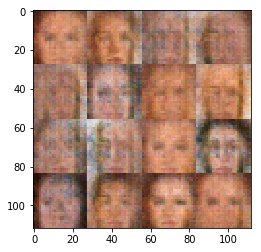

epoch 0 batch 310, d_loss: 0.270792 g_loss 1.414415
epoch 0 batch 320, d_loss: 0.133420 g_loss 2.195573
epoch 0 batch 330, d_loss: 0.173522 g_loss 2.057536
epoch 0 batch 340, d_loss: 0.064099 g_loss 3.401152
epoch 0 batch 350, d_loss: 0.115006 g_loss 2.882195
epoch 0 batch 360, d_loss: 0.271079 g_loss 3.107712
epoch 0 batch 370, d_loss: 1.930491 g_loss 8.980349
epoch 0 batch 380, d_loss: 0.379954 g_loss 1.207709
epoch 0 batch 390, d_loss: 0.600313 g_loss 6.249940
epoch 0 batch 400, d_loss: 0.732479 g_loss 6.624025


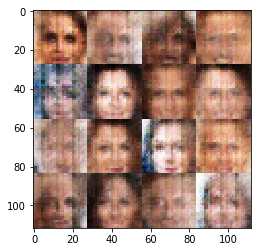

epoch 0 batch 410, d_loss: 0.233558 g_loss 5.166812
epoch 0 batch 420, d_loss: 0.679822 g_loss 9.248727
epoch 0 batch 430, d_loss: 0.097953 g_loss 4.414691
epoch 0 batch 440, d_loss: 0.107165 g_loss 2.536569
epoch 0 batch 450, d_loss: 0.226897 g_loss 1.619116
epoch 0 batch 460, d_loss: 0.215200 g_loss 5.434020
epoch 0 batch 470, d_loss: 0.239064 g_loss 3.675399
epoch 0 batch 480, d_loss: 0.121339 g_loss 3.522971
epoch 0 batch 490, d_loss: 0.916806 g_loss 0.353665
epoch 0 batch 500, d_loss: 0.311584 g_loss 2.340076


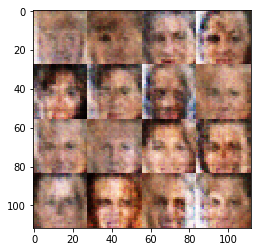

epoch 0 batch 510, d_loss: 0.133003 g_loss 3.482653
epoch 0 batch 520, d_loss: 0.046699 g_loss 4.436110
epoch 0 batch 530, d_loss: 0.071684 g_loss 3.040243
epoch 0 batch 540, d_loss: 0.776717 g_loss 0.469089
epoch 0 batch 550, d_loss: 0.192683 g_loss 2.493391
epoch 0 batch 560, d_loss: 0.330844 g_loss 1.753298
epoch 0 batch 570, d_loss: 0.363341 g_loss 1.354075
epoch 0 batch 580, d_loss: 0.226245 g_loss 2.963532
epoch 0 batch 590, d_loss: 0.531751 g_loss 0.882533
epoch 0 batch 600, d_loss: 1.251351 g_loss 4.607741


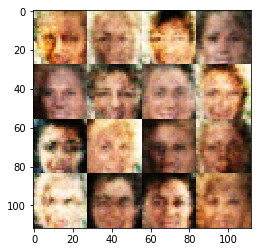

epoch 0 batch 610, d_loss: 0.193275 g_loss 2.420724
epoch 0 batch 620, d_loss: 0.749127 g_loss 0.575631
epoch 0 batch 630, d_loss: 1.114996 g_loss 0.220064
epoch 0 batch 640, d_loss: 0.395132 g_loss 2.375223
epoch 0 batch 650, d_loss: 0.453754 g_loss 0.895527
epoch 0 batch 660, d_loss: 1.496891 g_loss 6.933200
epoch 0 batch 670, d_loss: 0.456589 g_loss 1.015716
epoch 0 batch 680, d_loss: 0.467689 g_loss 1.156229
epoch 0 batch 690, d_loss: 0.667438 g_loss 0.740927
epoch 0 batch 700, d_loss: 0.202352 g_loss 3.259009


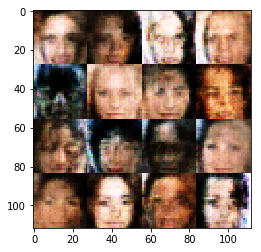

epoch 0 batch 710, d_loss: 0.309467 g_loss 1.962032
epoch 0 batch 720, d_loss: 0.258812 g_loss 1.564039
epoch 0 batch 730, d_loss: 0.361839 g_loss 1.042803
epoch 0 batch 740, d_loss: 0.178101 g_loss 2.469806
epoch 0 batch 750, d_loss: 0.395204 g_loss 1.344528
epoch 0 batch 760, d_loss: 0.677100 g_loss 2.783433
epoch 0 batch 770, d_loss: 0.363942 g_loss 1.588522
epoch 0 batch 780, d_loss: 0.074358 g_loss 2.988405
epoch 0 batch 790, d_loss: 0.618379 g_loss 0.639210
epoch 0 batch 800, d_loss: 0.158185 g_loss 2.351335


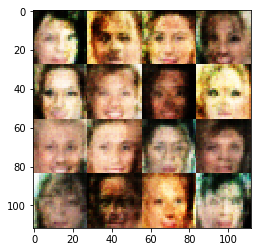

epoch 0 batch 810, d_loss: 0.391905 g_loss 1.000775
epoch 0 batch 820, d_loss: 0.293777 g_loss 1.486384
epoch 0 batch 830, d_loss: 0.729648 g_loss 5.004116
epoch 0 batch 840, d_loss: 0.530079 g_loss 0.753749
epoch 0 batch 850, d_loss: 0.538582 g_loss 3.648491
epoch 0 batch 860, d_loss: 0.245261 g_loss 2.450006
epoch 0 batch 870, d_loss: 0.234851 g_loss 2.040375
epoch 0 batch 880, d_loss: 0.903972 g_loss 4.927985
epoch 0 batch 890, d_loss: 0.093226 g_loss 2.919357
epoch 0 batch 900, d_loss: 0.259766 g_loss 3.351825


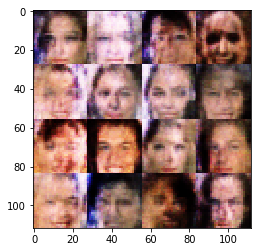

epoch 0 batch 910, d_loss: 0.322966 g_loss 1.485802
epoch 0 batch 920, d_loss: 0.134980 g_loss 2.653882
epoch 0 batch 930, d_loss: 2.231157 g_loss 7.397864
epoch 0 batch 940, d_loss: 0.302010 g_loss 1.973620
epoch 0 batch 950, d_loss: 0.656407 g_loss 0.737918
epoch 0 batch 960, d_loss: 0.252901 g_loss 1.480263
epoch 0 batch 970, d_loss: 0.522669 g_loss 0.815927
epoch 0 batch 980, d_loss: 0.564800 g_loss 0.638883
epoch 0 batch 990, d_loss: 0.150509 g_loss 2.785874
epoch 0 batch 1000, d_loss: 0.132984 g_loss 2.390001


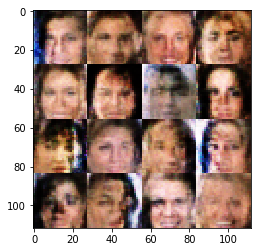

epoch 0 batch 1010, d_loss: 0.432821 g_loss 0.943106
epoch 0 batch 1020, d_loss: 0.181128 g_loss 2.673372
epoch 0 batch 1030, d_loss: 0.671885 g_loss 0.593453
epoch 0 batch 1040, d_loss: 0.649890 g_loss 3.292388
epoch 0 batch 1050, d_loss: 0.698100 g_loss 0.474903
epoch 0 batch 1060, d_loss: 0.734428 g_loss 4.242338
epoch 0 batch 1070, d_loss: 0.647216 g_loss 0.736161
epoch 0 batch 1080, d_loss: 0.480671 g_loss 2.636823
epoch 0 batch 1090, d_loss: 0.095744 g_loss 3.987136
epoch 0 batch 1100, d_loss: 0.685883 g_loss 0.552202


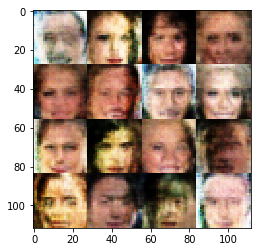

epoch 0 batch 1110, d_loss: 0.107357 g_loss 3.116240
epoch 0 batch 1120, d_loss: 0.307432 g_loss 2.178681
epoch 0 batch 1130, d_loss: 0.163188 g_loss 2.943908
epoch 0 batch 1140, d_loss: 0.116458 g_loss 2.252319
epoch 0 batch 1150, d_loss: 0.185794 g_loss 1.918710
epoch 0 batch 1160, d_loss: 0.063852 g_loss 3.434626
epoch 0 batch 1170, d_loss: 0.974988 g_loss 5.309906
epoch 0 batch 1180, d_loss: 0.044913 g_loss 3.981398
epoch 0 batch 1190, d_loss: 0.416999 g_loss 2.237071
epoch 0 batch 1200, d_loss: 0.471694 g_loss 0.886583


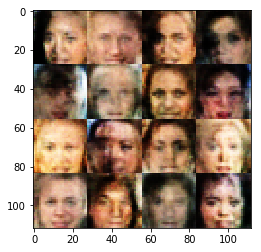

epoch 0 batch 1210, d_loss: 0.391510 g_loss 4.084824
epoch 0 batch 1220, d_loss: 0.214904 g_loss 1.601210
epoch 0 batch 1230, d_loss: 1.549610 g_loss 6.080050
epoch 0 batch 1240, d_loss: 0.669153 g_loss 0.581557
epoch 0 batch 1250, d_loss: 0.226410 g_loss 3.308067
epoch 0 batch 1260, d_loss: 0.148661 g_loss 4.369740
epoch 0 batch 1270, d_loss: 0.104714 g_loss 3.218338
epoch 0 batch 1280, d_loss: 0.320179 g_loss 1.374212
epoch 0 batch 1290, d_loss: 0.138650 g_loss 3.149480
epoch 0 batch 1300, d_loss: 0.431281 g_loss 0.850869


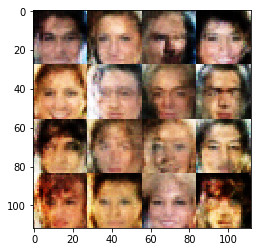

epoch 0 batch 1310, d_loss: 0.087854 g_loss 4.330028
epoch 0 batch 1320, d_loss: 0.112911 g_loss 4.720001
epoch 0 batch 1330, d_loss: 1.030980 g_loss 5.317369
epoch 0 batch 1340, d_loss: 0.299490 g_loss 2.791837
epoch 0 batch 1350, d_loss: 0.284022 g_loss 2.925583
epoch 0 batch 1360, d_loss: 0.069593 g_loss 3.762388
epoch 0 batch 1370, d_loss: 0.268860 g_loss 2.830528
epoch 0 batch 1380, d_loss: 0.065773 g_loss 4.262962
epoch 0 batch 1390, d_loss: 0.367357 g_loss 3.555068
epoch 0 batch 1400, d_loss: 0.280238 g_loss 1.784708


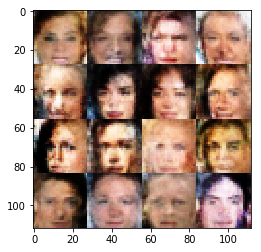

epoch 0 batch 1410, d_loss: 0.318576 g_loss 1.164980
epoch 0 batch 1420, d_loss: 0.190354 g_loss 1.734821
epoch 0 batch 1430, d_loss: 1.071218 g_loss 5.739909
epoch 0 batch 1440, d_loss: 0.163451 g_loss 2.217918
epoch 0 batch 1450, d_loss: 0.139078 g_loss 3.897483
epoch 0 batch 1460, d_loss: 0.473514 g_loss 5.479411
epoch 0 batch 1470, d_loss: 0.159947 g_loss 3.185826
epoch 0 batch 1480, d_loss: 0.152206 g_loss 1.813845
epoch 0 batch 1490, d_loss: 0.136089 g_loss 4.811239
epoch 0 batch 1500, d_loss: 0.897766 g_loss 3.882061


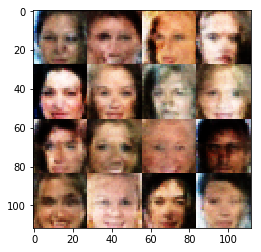

epoch 0 batch 1510, d_loss: 0.445466 g_loss 0.909669
epoch 0 batch 1520, d_loss: 0.317351 g_loss 1.337372
epoch 0 batch 1530, d_loss: 0.140824 g_loss 3.020763
epoch 0 batch 1540, d_loss: 0.279761 g_loss 1.331624
epoch 0 batch 1550, d_loss: 0.335646 g_loss 1.212301
epoch 0 batch 1560, d_loss: 0.082137 g_loss 3.018711
epoch 0 batch 1570, d_loss: 0.237758 g_loss 1.479748
epoch 0 batch 1580, d_loss: 0.292460 g_loss 2.863976
epoch 0 batch 1590, d_loss: 0.102612 g_loss 2.431386
epoch 0 batch 1600, d_loss: 0.068680 g_loss 4.404794


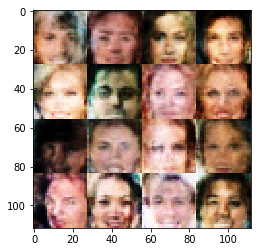

epoch 0 batch 1610, d_loss: 0.863641 g_loss 5.347529
epoch 0 batch 1620, d_loss: 0.212399 g_loss 1.660942
epoch 0 batch 1630, d_loss: 0.143060 g_loss 3.360247
epoch 0 batch 1640, d_loss: 0.985858 g_loss 5.809276
epoch 0 batch 1650, d_loss: 0.187965 g_loss 2.340091
epoch 0 batch 1660, d_loss: 0.350185 g_loss 1.234725
epoch 0 batch 1670, d_loss: 0.630981 g_loss 4.721460
epoch 0 batch 1680, d_loss: 0.286375 g_loss 3.589348
epoch 0 batch 1690, d_loss: 0.323851 g_loss 1.772416
epoch 0 batch 1700, d_loss: 0.260554 g_loss 6.067820


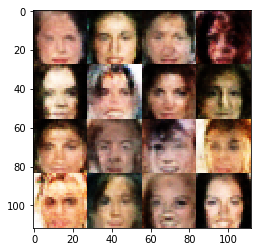

epoch 0 batch 1710, d_loss: 0.085881 g_loss 2.990994
epoch 0 batch 1720, d_loss: 0.300944 g_loss 4.429565
epoch 0 batch 1730, d_loss: 0.946407 g_loss 0.424837
epoch 0 batch 1740, d_loss: 0.233466 g_loss 5.159692
epoch 0 batch 1750, d_loss: 0.180404 g_loss 1.743562
epoch 0 batch 1760, d_loss: 0.402769 g_loss 1.063154
epoch 0 batch 1770, d_loss: 0.086691 g_loss 3.539682
epoch 0 batch 1780, d_loss: 0.358619 g_loss 1.139729
epoch 0 batch 1790, d_loss: 0.299204 g_loss 3.126638
epoch 0 batch 1800, d_loss: 0.433317 g_loss 5.251329


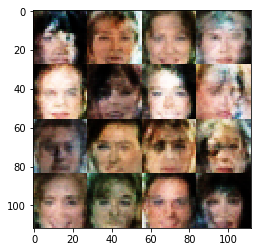

epoch 0 batch 1810, d_loss: 0.041336 g_loss 3.865592
epoch 0 batch 1820, d_loss: 0.059960 g_loss 3.616715
epoch 0 batch 1830, d_loss: 0.224737 g_loss 2.861022
epoch 0 batch 1840, d_loss: 0.121649 g_loss 2.444250
epoch 0 batch 1850, d_loss: 0.185563 g_loss 5.598189
epoch 0 batch 1860, d_loss: 0.679035 g_loss 0.601250
epoch 0 batch 1870, d_loss: 0.064289 g_loss 4.755721
epoch 0 batch 1880, d_loss: 0.091599 g_loss 3.789864
epoch 0 batch 1890, d_loss: 0.068343 g_loss 2.960427
epoch 0 batch 1900, d_loss: 0.041178 g_loss 3.950468


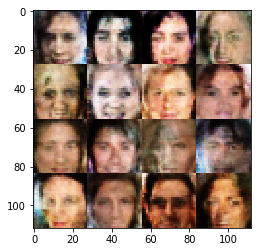

epoch 0 batch 1910, d_loss: 0.277479 g_loss 1.560595
epoch 0 batch 1920, d_loss: 0.132820 g_loss 2.307457
epoch 0 batch 1930, d_loss: 0.290698 g_loss 4.311865
epoch 0 batch 1940, d_loss: 0.051786 g_loss 6.902219
epoch 0 batch 1950, d_loss: 0.069633 g_loss 4.040006
epoch 0 batch 1960, d_loss: 0.753524 g_loss 5.308320
epoch 0 batch 1970, d_loss: 0.081596 g_loss 4.343945
epoch 0 batch 1980, d_loss: 0.025023 g_loss 4.985518
epoch 0 batch 1990, d_loss: 0.149653 g_loss 2.202029
epoch 0 batch 2000, d_loss: 0.053804 g_loss 4.824782


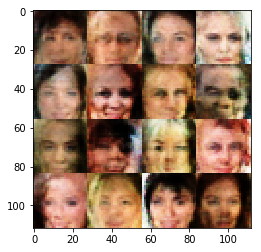

epoch 0 batch 2010, d_loss: 0.081654 g_loss 6.336483
epoch 0 batch 2020, d_loss: 0.043951 g_loss 3.968148
epoch 0 batch 2030, d_loss: 0.306069 g_loss 2.243108
epoch 0 batch 2040, d_loss: 0.386830 g_loss 3.866652
epoch 0 batch 2050, d_loss: 0.111708 g_loss 3.447550
epoch 0 batch 2060, d_loss: 0.616180 g_loss 0.640303
epoch 0 batch 2070, d_loss: 0.185348 g_loss 2.851442
epoch 0 batch 2080, d_loss: 0.438614 g_loss 0.928365
epoch 0 batch 2090, d_loss: 0.793660 g_loss 0.441245
epoch 0 batch 2100, d_loss: 0.202756 g_loss 3.298780


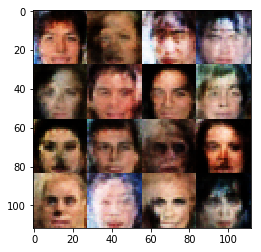

epoch 0 batch 2110, d_loss: 0.118261 g_loss 2.663083
epoch 0 batch 2120, d_loss: 0.416919 g_loss 4.941037
epoch 0 batch 2130, d_loss: 0.138846 g_loss 2.539351
epoch 0 batch 2140, d_loss: 0.130271 g_loss 5.209402
epoch 0 batch 2150, d_loss: 0.156990 g_loss 2.877370
epoch 0 batch 2160, d_loss: 0.090848 g_loss 3.286855
epoch 0 batch 2170, d_loss: 0.058169 g_loss 3.601800
epoch 0 batch 2180, d_loss: 0.159769 g_loss 3.899601
epoch 0 batch 2190, d_loss: 0.122823 g_loss 5.653656
epoch 0 batch 2200, d_loss: 0.334542 g_loss 4.933736


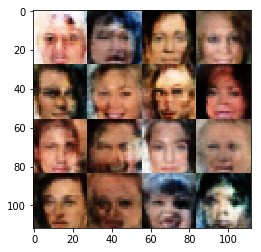

epoch 0 batch 2210, d_loss: 0.512909 g_loss 4.964481
epoch 0 batch 2220, d_loss: 0.196516 g_loss 2.862776
epoch 0 batch 2230, d_loss: 0.035525 g_loss 5.409963
epoch 0 batch 2240, d_loss: 0.280126 g_loss 1.297696
epoch 0 batch 2250, d_loss: 0.132613 g_loss 6.248523
epoch 0 batch 2260, d_loss: 0.054241 g_loss 3.171454
epoch 0 batch 2270, d_loss: 0.082593 g_loss 3.198123
epoch 0 batch 2280, d_loss: 0.064956 g_loss 3.653461
epoch 0 batch 2290, d_loss: 0.095461 g_loss 2.607801
epoch 0 batch 2300, d_loss: 0.206006 g_loss 3.174144


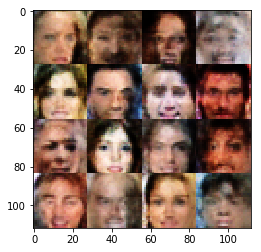

epoch 0 batch 2310, d_loss: 0.047266 g_loss 3.659248
epoch 0 batch 2320, d_loss: 0.576293 g_loss 7.147105
epoch 0 batch 2330, d_loss: 0.059668 g_loss 3.769721
epoch 0 batch 2340, d_loss: 0.223215 g_loss 1.589924
epoch 0 batch 2350, d_loss: 1.878741 g_loss 0.055242
epoch 0 batch 2360, d_loss: 0.251648 g_loss 2.265526
epoch 0 batch 2370, d_loss: 0.084953 g_loss 5.562263
epoch 0 batch 2380, d_loss: 0.516670 g_loss 0.863856
epoch 0 batch 2390, d_loss: 0.158042 g_loss 3.034961
epoch 0 batch 2400, d_loss: 0.064537 g_loss 3.763686


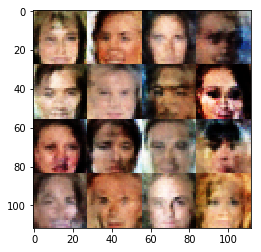

epoch 0 batch 2410, d_loss: 0.063627 g_loss 5.726892
epoch 0 batch 2420, d_loss: 0.065879 g_loss 6.505917
epoch 0 batch 2430, d_loss: 0.034795 g_loss 4.759925
epoch 0 batch 2440, d_loss: 0.092289 g_loss 2.810970
epoch 0 batch 2450, d_loss: 0.096899 g_loss 2.323348
epoch 0 batch 2460, d_loss: 0.118749 g_loss 2.425314
epoch 0 batch 2470, d_loss: 0.073416 g_loss 6.625628
epoch 0 batch 2480, d_loss: 0.083933 g_loss 2.673775
epoch 0 batch 2490, d_loss: 0.137961 g_loss 2.308298
epoch 0 batch 2500, d_loss: 0.472281 g_loss 5.247812


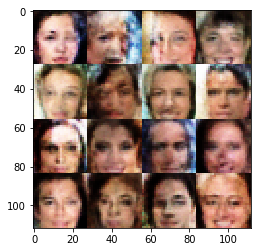

epoch 0 batch 2510, d_loss: 0.915668 g_loss 0.474550
epoch 0 batch 2520, d_loss: 0.290789 g_loss 1.566651
epoch 0 batch 2530, d_loss: 0.535683 g_loss 5.063240
epoch 0 batch 2540, d_loss: 0.056667 g_loss 5.415751
epoch 0 batch 2550, d_loss: 0.224370 g_loss 3.655285
epoch 0 batch 2560, d_loss: 0.134357 g_loss 2.273379
epoch 0 batch 2570, d_loss: 0.132354 g_loss 2.524125
epoch 0 batch 2580, d_loss: 0.073390 g_loss 4.182915
epoch 0 batch 2590, d_loss: 0.090584 g_loss 3.135211
epoch 0 batch 2600, d_loss: 2.014315 g_loss 0.070792


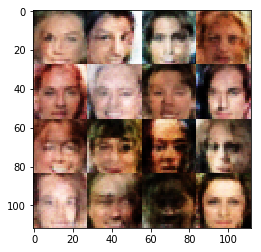

epoch 0 batch 2610, d_loss: 0.339856 g_loss 3.255669
epoch 0 batch 2620, d_loss: 0.459755 g_loss 4.434117
epoch 0 batch 2630, d_loss: 0.234538 g_loss 2.654370
epoch 0 batch 2640, d_loss: 0.081314 g_loss 3.012114
epoch 0 batch 2650, d_loss: 0.096971 g_loss 3.648833
epoch 0 batch 2660, d_loss: 0.085620 g_loss 3.140163
epoch 0 batch 2670, d_loss: 0.604972 g_loss 0.730797
epoch 0 batch 2680, d_loss: 0.102792 g_loss 3.874827
epoch 0 batch 2690, d_loss: 0.404600 g_loss 4.082188
epoch 0 batch 2700, d_loss: 0.059720 g_loss 3.545828


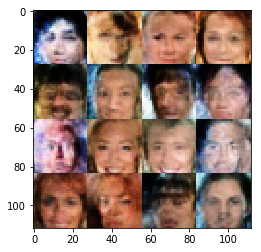

epoch 0 batch 2710, d_loss: 0.233158 g_loss 3.861812
epoch 0 batch 2720, d_loss: 0.088682 g_loss 2.876131
epoch 0 batch 2730, d_loss: 1.021161 g_loss 5.526658
epoch 0 batch 2740, d_loss: 0.130084 g_loss 2.900339
epoch 0 batch 2750, d_loss: 0.194998 g_loss 1.885635
epoch 0 batch 2760, d_loss: 0.052742 g_loss 3.579794
epoch 0 batch 2770, d_loss: 0.091863 g_loss 3.972447
epoch 0 batch 2780, d_loss: 0.247750 g_loss 4.237691
epoch 0 batch 2790, d_loss: 0.318753 g_loss 1.799714
epoch 0 batch 2800, d_loss: 0.638950 g_loss 4.398397


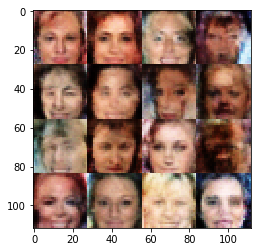

epoch 0 batch 2810, d_loss: 0.311741 g_loss 1.494504
epoch 0 batch 2820, d_loss: 0.046595 g_loss 4.245227
epoch 0 batch 2830, d_loss: 0.204914 g_loss 2.514533
epoch 0 batch 2840, d_loss: 0.055125 g_loss 3.964853
epoch 0 batch 2850, d_loss: 0.101456 g_loss 3.644564
epoch 0 batch 2860, d_loss: 0.036311 g_loss 4.460586
epoch 0 batch 2870, d_loss: 0.171735 g_loss 3.760637
epoch 0 batch 2880, d_loss: 0.295479 g_loss 5.602440
epoch 0 batch 2890, d_loss: 0.788206 g_loss 0.778661
epoch 0 batch 2900, d_loss: 0.238388 g_loss 1.910509


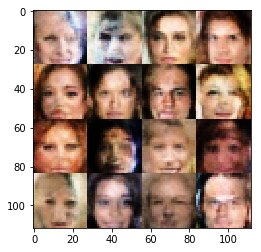

epoch 0 batch 2910, d_loss: 0.353243 g_loss 3.799191
epoch 0 batch 2920, d_loss: 0.254090 g_loss 1.487416
epoch 0 batch 2930, d_loss: 0.235955 g_loss 2.541167
epoch 0 batch 2940, d_loss: 0.111520 g_loss 4.319130
epoch 0 batch 2950, d_loss: 0.168348 g_loss 2.133486
epoch 0 batch 2960, d_loss: 0.247698 g_loss 5.610724
epoch 0 batch 2970, d_loss: 0.129771 g_loss 4.854543
epoch 0 batch 2980, d_loss: 0.373455 g_loss 1.202525
epoch 0 batch 2990, d_loss: 0.547514 g_loss 0.942241
epoch 0 batch 3000, d_loss: 0.171284 g_loss 1.978872


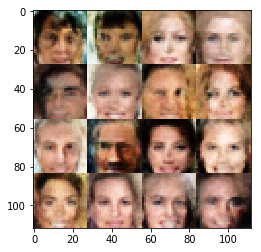

epoch 0 batch 3010, d_loss: 0.072057 g_loss 4.075942
epoch 0 batch 3020, d_loss: 0.265111 g_loss 3.764851
epoch 0 batch 3030, d_loss: 0.113416 g_loss 3.774466
epoch 0 batch 3040, d_loss: 0.035637 g_loss 4.507631
epoch 0 batch 3050, d_loss: 0.449248 g_loss 3.709762
epoch 0 batch 3060, d_loss: 0.156042 g_loss 3.179819
epoch 0 batch 3070, d_loss: 0.367213 g_loss 1.064613
epoch 0 batch 3080, d_loss: 0.248575 g_loss 4.265139
epoch 0 batch 3090, d_loss: 0.065183 g_loss 4.285156
epoch 0 batch 3100, d_loss: 0.172425 g_loss 1.987413


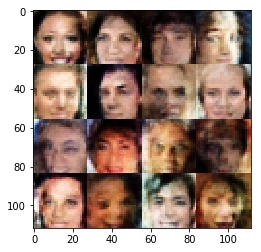

epoch 0 batch 3110, d_loss: 0.021301 g_loss 7.797739
epoch 0 batch 3120, d_loss: 0.319663 g_loss 4.558860
epoch 0 batch 3130, d_loss: 0.069471 g_loss 3.962506
epoch 0 batch 3140, d_loss: 0.715505 g_loss 0.606857
epoch 0 batch 3150, d_loss: 0.475146 g_loss 4.987857
epoch 0 batch 3160, d_loss: 0.276323 g_loss 2.812865


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    d_loss, g_loss = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

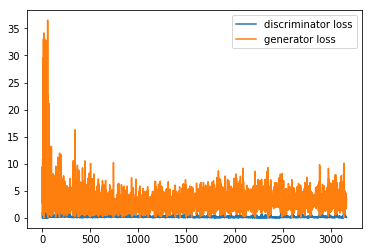

In [46]:
plt.plot(d_loss)
plt.plot(g_loss)
plt.legend(['discriminator loss', 'generator loss'])

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.